# Movie Scripts Analyzis & Training Experiments

### Dataset: https://www.kaggle.com/datasets/gufukuro/movie-scripts-corpus
### *TODO: Add experiments with passing script chunks to the model instead of raw lines*

## Imports, Helpers, Configuration

In [1]:
import pickle
import random
import os
from pathlib import Path
import pandas as pd 

In [2]:
DATA_ROOT = Path("/kaggle/input/movie-scripts-corpus")
MOVIE_CHARACTER_DATA_DIR = DATA_ROOT / "movie_characters/data"
MOVIE_CHARACTER_GENDERS_PATH = MOVIE_CHARACTER_DATA_DIR / "character_genders.pickle"
MOVIE_CHARACTER_TEXTS_DIR = MOVIE_CHARACTER_DATA_DIR / "movie_character_texts/movie_character_texts"
MOVIE_METADATA_DIR = DATA_ROOT / "movie_metadata"
SCREENPLAY_DATA_DIR = DATA_ROOT / "screenplay_data/data"
BERT_ANNOTATIONS_DIR = SCREENPLAY_DATA_DIR / "BERT_annotations" / "BERT_annotations"
MANUAL_ANNOTATIONS_DIR = SCREENPLAY_DATA_DIR / "manual_annotations" / "manual_annotations"
SEED = 11

In [3]:
random.seed(SEED)

In [4]:
def write_file(file: str, path: str):
    extension = os.path.splitext(path)[1]
    if extension == ".pickle":
        with open(path, "wb") as f:
            pickle.dump(file, f)


def read_file(path: str, **kwargs):
    extension = os.path.splitext(path)[1]
    try:
        if extension == ".pickle":
            with open(path, "rb") as f:
                file = pickle.load(f)
        elif extension == ".txt":
            if kwargs.get("read_lines"):
                file = open(path, "r", encoding="utf-8").readlines()
            else:
                file = open(path, "r", encoding="utf-8").read()
        else:
            print("Unknown extension")
            return None
    except FileNotFoundError:
        print("File not found")
        return None
    return file

bold_text = lambda text: '\033[1m' + text + '\033[0m'

## Check Dataset

### Movie Characters

In [5]:
# Take a look at movie characters information
character_genders = read_file(MOVIE_CHARACTER_GENDERS_PATH)
random_movie_imdb_id = random.sample(sorted(character_genders), k=10)

for movie_imdb_id in random_movie_imdb_id:
    print(bold_text("IMDB ID: "), movie_imdb_id)
    characters = character_genders[movie_imdb_id]
    for character in characters:
        print(f"Character: {character[0]}; Type: {character[1]}")
    print()
    

IMDB ID:  1620466
Character: Lila Lorenz; Type: actress
Character: Chriz; Type: actor
Character: Dr. Angelika Lorenz; Type: actress
Character: Tom; Type: actor

IMDB ID:  4357714
Character: Edna Greenleaf; Type: actress
Character: Steve Burns; Type: actor
Character: Eddie Greenleaf; Type: actor
Character: Jess White; Type: actress

IMDB ID:  1773552
Character: Modesto Marchena; Type: actor
Character: Manuel Marchena; Type: actor
Character: Susanita Marchena; Type: actress
Character: Mamá Susana Marchena; Type: actress

IMDB ID:  1612768
Character: Tomas; Type: actor
Character: Sergeant Yanto; Type: actor
Character: Lastri; Type: actress
Character: The Kiyaii; Type: actor

IMDB ID:  2476682
Character: Bad Angel; Type: actress
Character: Alexander's Paramour; Type: actress
Character: Duke; Type: actor
Character: Fredrick; Type: actor
Character: First Student; Type: actor
Character: Dick; Type: actor
Character: First Scholar; Type: actor
Character: Friar Sandelo; Type: actor
Character: Lu

In [6]:
# Check character texts/dialogs
# For details, please check readme.txt at /kaggle/input/movie-scripts-corpus/movie_characters/readme.txt
movie_character_texts = os.listdir(MOVIE_CHARACTER_TEXTS_DIR)
movie_character_texts_count = len(movie_character_texts)
print(f"{bold_text('Number of movie dirs in movie_character_texts folder: ')}{movie_character_texts_count}")
print("----------------------------------------------------------\n")

random_movies_with_character_texts = random.sample(movie_character_texts, k=10)
for movie in random_movies_with_character_texts:
    movie_name, imbd_id = movie.split("_")
    character_text_files = os.listdir(MOVIE_CHARACTER_TEXTS_DIR / movie)
    character_text_files_num = len(character_text_files)
    print(f"{bold_text('Movie name: ')}{movie_name} ({bold_text('IMDB ID: ')}{imbd_id})")
    print(f"{bold_text('Number of character text files: ')}{character_text_files_num}")

    random_character_text_file_index = random.randint(0, character_text_files_num - 1)
    random_character_text_file = character_text_files[random_character_text_file_index]
    random_character_text_file_lines = read_file(MOVIE_CHARACTER_TEXTS_DIR / movie / random_character_text_file, read_lines=True)
    random_character_text_file_lines_num = len(random_character_text_file_lines)
    chosen_character, _ = character_text_files[random_character_text_file_index].split("_")
    lines_to_show_num = min(random_character_text_file_lines_num, 5)
    print(f"{bold_text('Chosen character: ')}{chosen_character}")
    print(f"{bold_text('Number of text lines: ')}{random_character_text_file_lines_num}")
    print(f"{bold_text('Example ')}({lines_to_show_num} lines):")
    if lines_to_show_num > random_character_text_file_lines_num:
        random_rows_chunk_start = random.randint(0, random_character_text_file_lines_num - lines_to_show_num - 1)
    else:
        random_rows_chunk_start = 0
    lines_to_show = random_character_text_file_lines[random_rows_chunk_start: random_rows_chunk_start + lines_to_show_num]
    lines_to_show = list(map(lambda x: "   " + x, lines_to_show))
    print(''.join(lines_to_show))
    print()

Number of movie dirs in movie_character_texts folder: 2153
----------------------------------------------------------

Movie name: What Price Hollywood (IMDB ID: 0023686)
Number of character text files: 14
Chosen character: Julius Saxe
Number of text lines: 2
Example (2 lines):
   63) 0) text: MED. LONG SHOT. A truck drives by with music and carrying big sign, "See Mary Evans' Latest Picture 'GIRL OF FLAMBE' a Julius Saxe Super Production." cur TO
   118) 9) dialog: P.S. And you better re-marry Lonny Borden. He loves you ... he has always loved you... he isn't good enough for you but he'll do anything if you'll - take him back. Hets really a marvelous young man and he adores you... (859) -

Movie name: Walking Tall (IMDB ID: 0351977)
Number of character text files: 13
Chosen character: Chris Vaughn
Number of text lines: 237
Example (5 lines):
   1) 0) text: Chris reads a closure notice on the door. A police car ro up.
   1) 3) dialog: Ok. When'd the mill close?
   1) 6) dialog: That's 

### Movie Metadata

In [7]:
metacritic_reviews_cut = pd.read_csv(MOVIE_METADATA_DIR / "metacritic_reviews_cut_versions.csv")
metacritic_reviews_cut

,id,text,score,imdbid
0,0,Because so little of what occurs on-screen eit...,4,242998
1,1,"Insufferably boring, culturally hegemonic, and...",5,1335975
2,2,The Roommate has notched an unbelievable achie...,5,1265990
3,3,The only thing about this movie that will haun...,6,160484
4,4,There are legitimate excuses for going to see ...,8,2120120
...,...,...,...,...
21019,21019,Edge of Tomorrow is the ultimate metaphor abou...,100,1631867
21020,21020,I've rarely seen so selfless a collection of p...,100,265086
21021,21021,One of the strongest of all American movies......,100,40897
21022,21022,"The depth, subtlety and wit of Pattinson and D...",100,6723592


In [8]:
movie_metadata = pd.read_csv(MOVIE_METADATA_DIR / "movie_meta_data.csv")
movie_metadata

,imdbid,title,akas,year,metascore,imdb user rating,number of imdb user votes,awards,opening weekend,producers,...,casting directors,cast,countries,age restrict,plot,plot outline,keywords,genres,taglines,synopsis
0,120770,A Night at the Roxbury,"Une nuit au Roxbury (France), Movida en el Rox...",1998,26,6,56537,NaN,United States:,"Marie Cantin, Erin Fraser, Amy Heckerling, Ste...",...,Jeff Greenberg,"Will Ferrell, Chris Kattan, Raquel Gardner, Vi...",United States,"Argentina:13, Australia:M, Brazil:14, Canada:P...",Two dim-witted brothers dream of owning their ...,"The Roxbury Guys, Steve and Doug Butabi, want ...","woman-on-top, nightclub, car-accident, 1990s, ...","Comedy, Music, Romance",Score!,NaN
1,132512,At First Sight,"Sight Unseen (United States), Premier regard (...",1999,40,6,12922,NaN,United States:,"Rob Cowan, Roger Paradiso, Irwin Winkler",...,"Kerry Barden, Billy Hopkins, Suzanne Smith","Val Kilmer, Mira Sorvino, Kelly McGillis, Stev...",United States,"Argentina:13, Australia:M, Canada:PG::(Alberta...",A blind man has an operation to regain his sig...,First Sight is true to the title from start to...,"visual-agnosia, brother-sister-relationship, r...","Drama, Romance","Only Love Can Bring You To Your Senses., Scien...",NaN
2,118661,The Avengers,"Chapeau melon et bottes de cuir (France), Mit ...",1998,12,3,40784,"FMCJ Award 1998, Golden Reel Award 1999, Razzi...","United States: $10,305,957, 16 Aug 1998","Susan Ekins, Jerry Weintraub",...,Susie Figgis,"Ralph Fiennes, Uma Thurman, Sean Connery, Patr...",United States,"Argentina:13, Australia:PG, Brazil:10, Canada:...",Two British Agents team up to stop Sir August ...,"British Ministry Agent John Steed, under direc...","good-versus-evil, heroine, evil-man, villain, ...","Action, Adventure, Sci-Fi, Thriller","Mrs. Peel, we're needed., Extraordinary crimes...",NaN
3,215545,Bamboozled,"The Very Black Show (France), It's Showtime (G...",2000,54,6,10373,"Golden Berlin Bear 2001, Black Reel 2001, Imag...",United States:,"Jon Kilik, Spike Lee, Kisha Imani Cameron",...,Aisha Coley,"Damon Wayans, Savion Glover, Jada Pinkett Smit...",United States,"Australia:MA, Finland:K-15, France:Tous public...",A frustrated African-American TV writer propos...,"Dark, biting satire of the television industry...","television-industry, african-american, referen...","Comedy, Drama, Music",Starring the great negroe actors,"In a New York City residence, Pierre Delacroix..."
4,118715,The Big Lebowski,"El gran Lebowski (Spain), O Grande Lebowski (P...",1998,71,8,724388,"Honorable Mention 1998, ACCA 1998, Golden Berl...","United States: $5,533,844, 08 Mar 1998","Tim Bevan, John Cameron, Ethan Coen, Eric Fell...",...,John S. Lyons,"Jeff Bridges, John Goodman, Julianne Moore, St...","United States, United Kingdom","Argentina:16, Argentina:18::(cable rating), Au...","Jeff ""The Dude"" Lebowski, mistaken for a milli...","When ""the dude"" Lebowski is mistaken for a mil...","rug, nihilism, pornographer, bowling-alley, de...","Comedy, Crime, Sport",Hay quienes tratan de ganarse la vida sin move...,A tumbleweed rolls up a hillside just outside ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2853,114924,While You Were Sleeping,"Coma Guy (United States), L'amour à tout prix ...",1995,67,6,90812,"Golden Globe 1996, American Comedy Award 1996,...",NaN,"Steve Barron, Roger Birnbaum, Jonathan Glickma...",...,"Cathy Sandrich Gelfond, Amanda Mackey","Sandra Bullock, Bill Pullman, Peter Gallagher,...",United States,"Argentina:Atp, Australia:PG, Brazil:12, Finlan...",A hopelessly romantic Chicago Transit Authorit...,Nursing a secret and hopeless crush on the han...,"loneliness, unconventional-romance, holiday-se...","Comedy, Drama, Romance",A story about love at second sight.,"Sandra Bullock plays Lucy Ellenore Moderatz, a..."
2854,3011894,Wild Tales,"Les Nouveaux Sauvages (France), Wild Tales (Un...",2014,77,8,174075,"Oscar 2015, BAFTA Film Award 2016, Award of th...",Na

In [9]:
screenplay_awards = pd.read_csv(MOVIE_METADATA_DIR / "screenplay_awards.csv")
screenplay_awards

,movie,Academy Awards adapted screenplay,Academy Awards original screenplay,BAFTA nominations,Golden Globe Award for Best Screenplay,Writers Guild Awards Winners & Nominees 2020-2013
0,A Tree Grows in Brooklyn_0038190,+,-,-,-,-
1,Winter s Bone_1399683,+,-,-,-,-
2,The Hustler_0054997,+,-,-,-,-
3,Leaving Las Vegas_0113627,+,-,+,-,-
4,Before Midnight_2209418,+,-,-,-,+
...,...,...,...,...,...,...
457,Deadpool_1431045,-,-,-,-,+
458,Looper_1276104,-,-,-,-,+
459,The Perks of Being a Wallflower_1659337,-,-,-,-,+
460,Kingsman Theory of Everything Foxcatcher_4682196,-,-,-,-,+


### Screenplay Data

In [10]:
# Check annotations by structural elements obtained with BERT
# For details, please check readme.txt at /kaggle/input/movie-scripts-corpus/screenplay_data/readme.txt
bert_annotations = os.listdir(BERT_ANNOTATIONS_DIR)
bert_annotations_count = len(bert_annotations)
print(bold_text("Number of screenplays annotated with BERT: "), bert_annotations_count)
print("------------------------------------------------\n")

random_bert_annotations = random.sample(bert_annotations, k=10)
for random_bert_annotation in random_bert_annotations:
    movie_name, imdb_id, _ = random_bert_annotation.split("_")
    print(f"{bold_text('Movie name: ')}{movie_name} ({bold_text('IMDB ID: ')}{imbd_id})")
    annotation = read_file(BERT_ANNOTATIONS_DIR / random_bert_annotation, read_lines=True)
    annotated_lines_num = len(annotation)
    lines_to_show_num = min(annotated_lines_num, 20)
    random_rows_chunk_start = random.randint(0, annotated_lines_num - lines_to_show_num - 1) if annotated_lines_num > 20 else 0
    print(f"{bold_text('Annotated lines num: ')}{annotated_lines_num}")
    print(f"{bold_text('Example ')}({lines_to_show_num} lines):")
    lines_to_show = annotation[random_rows_chunk_start: random_rows_chunk_start + 20]
    lines_to_show = list(map(lambda x: "   " + x, lines_to_show))
    print("".join(lines_to_show))
        

Number of screenplays annotated with BERT:  1998
------------------------------------------------

Movie name: The Company of Wolves (IMDB ID: 1142988)
Annotated lines num: 1779
Example (20 lines):
   text: FATHER clicks his rifle shut, gets up. ROSALEEN helps him into a heavy dark
   dialog: cloak.
   dialog: MOTHER: Take care, won't you? And take this.
   text: She holds up a crucifix on a chain. He knocks it aside with the barrel of
   dialog: his rifle.
   dialog: FATHER: No. This is all these beasts understand. Kill them before they kill
   dialog: you.
   text: He goes out. Thunder. MOTHER hugs ROSALEEN.
   scene_heading: EXT. WOODS - NIGHT
   text: Heavy autumn mist. The villagers walk in single file carrying flaming
   dialog: torches.
   dialog: OLD VILLAGER Keep close! There was once a village so plagued by the beats
   dialog: they drew one up in the bucket of the well!
   dialog: FATHER: Hush your antique gossip unless you want the wolves to hear it!
   text: The BOY trudge

In [11]:
def preprocess_manual_annotation(text_lines):
    """Updates annotation text so that each line has a label."""
    labels = ("dialog", "scene_heading", "speaker_heading", "text")
    current_label = text_lines[0].split(":")[0]
    try:
        assert current_label in labels, "Unexpected label in the beginning if the text annotation."
    except AssertionError:
        print("ASSERTION:", text_lines[0])
        current_label = None
    text_updated = [text_lines[0]] if current_label else []
    for text_line in text_lines[1:]:
        text_line = text_line.strip()
        if not text_line or text_line.startswith("other: "):
            continue
        label = text_line.split(":")[0]
        if label in labels:
            current_label = label
            text_updated.append(text_line) #" \n"
        else:
            if current_label is None:
                continue
            text_updated.append(current_label + ": " + text_line) #  " \n"
    return text_updated

In [12]:
# Check manual annotations on structural elements
# For details, please check readme.txt at /kaggle/input/movie-scripts-corpus/screenplay_data/readme.txt
manual_annotations = os.listdir(MANUAL_ANNOTATIONS_DIR)
manual_annotations_count = len(manual_annotations)
print(bold_text("Number of screenplays annotated manually: "), manual_annotations_count)
print("---------------------------------------------\n")

random_manual_annotations = random.sample(manual_annotations, k=10)
for random_manual_annotation in random_manual_annotations:
    movie_name, imdb_id, _, _ = random_manual_annotation.split("_")
    print(f"{bold_text('Movie name: ')}{movie_name} ({bold_text('IMDB ID: ')}{imbd_id})")
    annotation = read_file(MANUAL_ANNOTATIONS_DIR / random_manual_annotation, read_lines=True)
    annotation_updated = preprocess_manual_annotation(annotation)
    annotated_lines_num = len(annotation_updated)
    lines_to_show_num = min(annotated_lines_num, 20)
    random_rows_chunk_start = random.randint(0, annotated_lines_num - lines_to_show_num - 1) if annotated_lines_num > 20 else 0
    print(f"{bold_text('Annotated lines num: ')}{annotated_lines_num}")
    print(f"{bold_text('Example ')}({lines_to_show_num} lines):")
    
    lines_to_show = annotation_updated[random_rows_chunk_start: random_rows_chunk_start + lines_to_show_num]
    lines_to_show = list(map(lambda x: "   " + x, lines_to_show))
    print("\n".join(lines_to_show))
    print()

Number of screenplays annotated manually:  33
---------------------------------------------

Movie name: Cloud Atlas (IMDB ID: 1142988)
ASSERTION: other: FADE IN:

Annotated lines num: 89
Example (20 lines):
   dialog: Ewing, Adam Ewing, Sir. Traveling
   dialog: with the “Prophetess”. They told me
   dialog: I could find you out here. Have you
   dialog: lost something?
   speaker_heading: GOOSE
   dialog: (a beat, then smiles)
   dialog: Teeth, sir are the enameled grails
   dialog: of the quest at hand. This beach
   dialog: was once a cannibal’s banqueting
   dialog: hall, where the strong gorged on
   dialog: the weak, but the teeth, the teeth
   dialog: sir, they spat out as you or I
   dialog: would expel a cherry stone. An
   dialog: artisan of Piccadilly who fashions
   dialog: denture sets for the nobility pays
   dialog: handsomely for human gnashers. Do
   dialog: you know the price a quarter pound
   dialog: will earn, sir?
   speaker_heading: EWING
   dialog: I confess, 

## Training experiments

### Imports, Helpers, Configuration

#### **After installing the libraries below, restart the kernel!**

In [13]:
!pip install trackio==0.13.1
!pip install transformers==4.57.3
!pip install pandas==2.3.3
!pip install numpy==1.26.4
!pip install pyarrow==22.0.0
!pip install evaluate==0.4.6
!pip install optuna

In [14]:
from kaggle_secrets import UserSecretsClient
import os

user_secrets = UserSecretsClient()
os.environ["HF_TOKEN"] = user_secrets.get_secret("HF_TOKEN")
os.environ["HF_SPACE_ID"] = user_secrets.get_secret("HF_SPACE_ID")

In [15]:
import os
import re
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset
from pydantic import PositiveFloat
from pydantic_settings import BaseSettings
from sklearn.model_selection import train_test_split
from enum import IntEnum
from collections import Counter
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import SubsetRandomSampler, DataLoader, Subset
import matplotlib.pyplot as plt
import optuna
import evaluate
import trackio
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback
from datasets import Dataset as HF_Dataset

2025-12-25 20:52:02.194042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766695922.215209     354 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766695922.221558     354 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [17]:
# Constants
DATA_DIR = Path("/kaggle/input/movie-scripts-corpus")
KAGGLE_OUTPUT_DIR = Path("/kaggle/working/")

SetType = IntEnum('SetType', ('train', 'validation', 'test'))

In [18]:
class PathSettings(BaseSettings):
    """Configuration for file system paths used throughout the application."""
    manual_annotations_dir: Path = DATA_DIR / "screenplay_data/data/manual_annotations/manual_annotations"
    tokenized_data_path: Path = KAGGLE_OUTPUT_DIR / "data_tokenized.pickle"
    training_split_path: Path = Path("/kaggle/working/train_validation_split.pickle")

class DataSettings(BaseSettings):
    heading_to_class_mapping: dict = {'scene_heading': 0, 'text': 1, 'speaker_heading': 2, 'dialog': 3}
    class_to_heading_mapping: dict = {0: 'scene_heading', 1: 'text', 2: 'speaker_heading', 3: 'dialog'}
    validation_size: float = 0.3
    classes_num: int = 4

class ModelSettings(BaseSettings):
    model_name: str = "answerdotai/ModernBERT-base" # From("google-bert/bert-base-cased", "answerdotai/ModernBERT-base")
    reference_compile: bool = False # Only for ModernBERT model

class TrainingSettings(BaseSettings):
    run_name: str = "base_experiment"
    output_dir: str = "./results"
    fp16: bool = True # Set bf16=True for GPU supporting this type
    per_device_train_batch_size:int = 16
    per_device_eval_batch_size: int = 16

    learning_rate: PositiveFloat = 5e-5
    lr_scheduler_type: str = "cosine"
    warmup_ratio: PositiveFloat = 0.1
    num_train_epochs: int = 5
    weight_decay: PositiveFloat = 0.05
    label_smoothing_factor: PositiveFloat = 0.1

    report_to: str | None = "trackio"
    trackio_space_id: str = os.environ["HF_SPACE_ID"]
    logging_steps: int = 10
    eval_strategy: str = "epoch"
    save_strategy: str = "epoch"
    eval_on_start: bool = True
    load_best_model_at_end: bool = True

    group_by_length: bool = True # To minimize padding
    dataloader_pin_memory: bool = True
    dataloader_num_workers: int = 4 # os.cpu_count()
    
class ValidationSettings(BaseSettings):
    trials_num: int
    learning_rate: dict = {"type": "float", "values": (1e-5, 5e-5), "args": {"log": True}}
    lr_scheduler_type: dict = {"type": "categorical", "values": (("linear", "cosine",),), "args": {}}
    warmup_ratio: dict = {"type": "float", "values": (0.0, 0.2), "args": {}}
    weight_decay: dict = {"type": "float", "values": (0.01, 0.1), "args": {}}
    label_smoothing_factor: dict = {"type": "float", "values": (0.0, 0.15), "args": {}}

    # Settings to update while running validation (e. g. number of epochs, evaluation strategy, etc)
    base_training_args: dict = {
        "output_dir": "./validation_results", "num_train_epochs": 3, "eval_on_start": False,
    }

In [19]:
def write_file(file: str, path: str):
    extension = os.path.splitext(path)[1]
    if extension == ".pickle":
        with open(path, "wb") as f:
            pickle.dump(file, f)


def read_file(path: str, **kwargs):
    extension = os.path.splitext(path)[1]
    try:
        if extension == ".pickle":
            with open(path, "rb") as f:
                file = pickle.load(f)
        elif extension == ".txt":
            if kwargs.get("read_lines"):
                file = open(path, "r").readlines()
            else:
                file = open(path, "r").read()
        else:
            print("Unknown extension")
            return None
    except FileNotFoundError:
        print("File not found")
        return None
    return file

In [20]:
def preprocess_manual_annotation(text_lines):
    """Updates annotation text so that each line has a label."""
    labels = ("dialog", "scene_heading", "speaker_heading", "text")
    current_label = text_lines[0].split(":")[0]
    try:
        assert current_label in labels, "Unexpected label in the beginning if the text annotation."
    except AssertionError:
        print("ASSERTION:", text_lines[0])
        current_label = None
    text_updated = [text_lines[0]] if current_label else []
    for text_line in text_lines[1:]:
        text_line = re.sub(" +", " ", text_line).replace("\t", "").strip()
        if not text_line or text_line.startswith("other: "):
            continue
        label = text_line.split(":")[0]
        if label in labels:
            current_label = label
            text_updated.append(text_line)
        else:
            if current_label is None:
                continue
            text_updated.append(current_label + ": " + text_line)
    return text_updated

### Dataset

In [21]:
class ScriptAnnotationDataset(Dataset):
    def __init__(self, path_settings: PathSettings, data_settings: DataSettings, model_tokenizer_name: str):
        self.path_settings = path_settings
        self.data_settings = data_settings
        self.preprocessor = AutoTokenizer.from_pretrained(model_tokenizer_name)

        # We have small annotated dataset so the data can be uploaded to the memory
        self._prepare_data()
        self._init_split()

    def read_annotations(self):
        annotations, imdb_ids, annotated_line_nums = [], [], []

        for annotation in os.listdir(self.path_settings.manual_annotations_dir):
            _, imdb_id, _, _ = annotation.split("_")
            annotation_text = read_file(self.path_settings.manual_annotations_dir / annotation, read_lines=True)
            annotation_text_preprocessed = preprocess_manual_annotation(annotation_text)
            annotations.append(annotation_text_preprocessed)
            imdb_ids.append(imdb_id)
            annotated_line_nums.append(len(annotation_text_preprocessed))
            
        imdb_ids = np.asarray(imdb_ids)
        annotated_line_nums =  np.asarray(annotated_line_nums)
        return annotations, imdb_ids, annotated_line_nums

    def preprocess_annotations(self, annotations, movie_imdb_ids):
        """Extracts and removes labels from the annotated lines."""
        if os.path.exists(self.path_settings.tokenized_data_path):
            return read_file(self.path_settings.tokenized_data_path)
        
        raw_lines, inputs, labels, line_imdb_ids = [], [], [], []
        heading_to_class_map = self.data_settings.heading_to_class_mapping

        for annotation, imdb_id in zip(annotations, movie_imdb_ids):
            for line in annotation:
                raw_lines.append(line)
                line_start = line.split(":")[0]
                # Asssuming labels were checked and corrected while reading annotations earlier
                label = heading_to_class_map[line_start]
                line = line.replace(line_start + ":", "")
                inputs.append(self.preprocessor.encode(line))
                labels.append(label)
                line_imdb_ids.append(imdb_id)

        write_file((raw_lines, inputs, labels, line_imdb_ids), self.path_settings.tokenized_data_path)
        return raw_lines, inputs, labels, line_imdb_ids
        
    def make_weights_for_balanced_classes(self, labels):     
        classes_num = len(self.data_settings.heading_to_class_mapping)
        count = [0] * classes_num

        for label in labels:                                                         
            count[label] += 1                                                     
        weight_per_class = [0.] * classes_num       

        total_samples_num = float(sum(count))                                                   
        for i in range(classes_num):                                                   
            weight_per_class[i] = total_samples_num / float(count[i])                                 
        weight = [0] * len(labels)                                              
        for idx, label in enumerate(labels):                                          
            weight[idx] = weight_per_class[label]

        return weight, weight_per_class 

    def compute_sample_lengths(self, inputs):
        """Precomputes sample lengths to use this information for more optimal batch creating while training."""
        return [len(sample) for sample in self.inputs]

    def _init_split(self):
        if os.path.exists(self.path_settings.training_split_path):
            split = read_file(self.path_settings.training_split_path)    
            self.train_indices = split.get("train_indices")
            self.validation_indices = split.get("validation_indices")
            print("Dataset split loaded.")
        else:
            print("Creating dataset split...")
            test_size = self.data_settings.validation_size
            df = pd.DataFrame({"annotated_line_nums": self.annotated_line_nums})
            df["annotated_line_nums_bin"] = pd.qcut(df["annotated_line_nums"], q=4, duplicates="drop")
            train_idx, validation_idx = train_test_split(
                df.index, test_size=test_size, stratify=df["annotated_line_nums_bin"], random_state=SEED,
            )
            train_movies = self.imdb_ids[train_idx]
            validation_movies = self.imdb_ids[validation_idx]
            self.train_indices = [i for i, x in enumerate(self.line_imdb_ids) if x in train_movies]
            self.validation_indices = [i for i, x in enumerate(self.line_imdb_ids) if x in validation_movies]
            assert set(self.train_indices) | set(self.validation_indices) == set(range(len(self.labels)))
            write_file({"train_indices": self.train_indices, "validation_indices": self.validation_indices}, self.path_settings.training_split_path)
            
        train_labels = [l for i, l in enumerate(self.labels) if i in self.train_indices]
        self.sample_weights, self.weight_per_class = self.make_weights_for_balanced_classes(train_labels)
        
    def _prepare_data(self):
        annotations, self.imdb_ids, self.annotated_line_nums = self.read_annotations()
        self.raw_lines, self.inputs, self.labels, self.line_imdb_ids = self.preprocess_annotations(annotations, self.imdb_ids)
        self.lengths = self.compute_sample_lengths(self.inputs)
        
    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int) -> dict:
        return {'input_ids': self.inputs[idx], 'labels': self.labels[idx], "length": self.lengths[idx]}

#### Check simple quantitative stats

In [22]:
dataset = ScriptAnnotationDataset(PathSettings(), DataSettings(), ModelSettings().model_name)
print("Number of annotated lines: ", len(dataset.inputs))

ASSERTION: other: FADE IN:

Dataset split loaded.
Number of annotated lines:  6211


Annotated lines lengths (in tokens) statistics:
Min: 2
Mean: 11.2
95th percentile: 20.0
98th percentile: 22.0
Max: 35


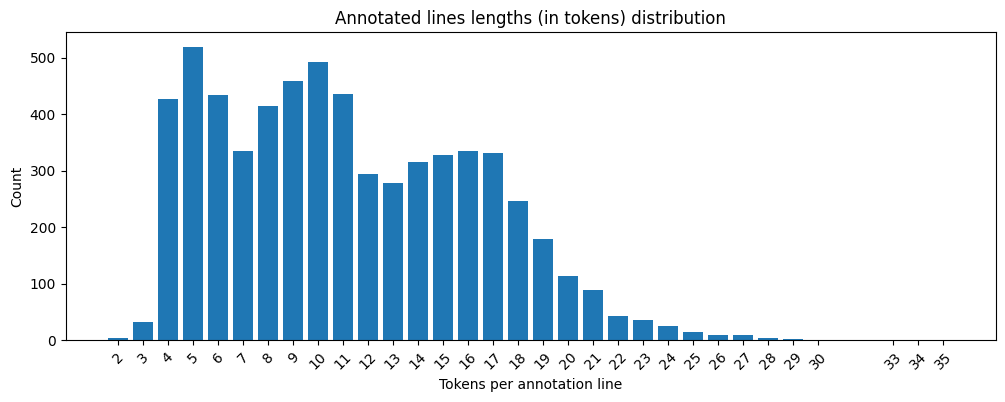

In [23]:
lengths = np.array([len(x) for x in dataset.inputs])
unique_lengths, counts = np.unique(lengths, return_counts=True)

print("Annotated lines lengths (in tokens) statistics:")
print(f"Min: {lengths.min()}")
print(f"Mean: {lengths.mean():.1f}")
print(f"95th percentile: {np.percentile(lengths, 95)}")
print(f"98th percentile: {np.percentile(lengths, 98)}")
print(f"Max: {lengths.max()}")

plt.figure(figsize=(12, 4))
plt.bar(unique_lengths, counts, align='center')
plt.xticks(unique_lengths, rotation=45)
plt.xlabel("Tokens per annotation line")
plt.ylabel("Count")
plt.title("Annotated lines lengths (in tokens) distribution")
plt.show()

In [24]:
unique_labels, label_counts = np.unique(dataset.labels, return_counts=True)
class_to_heading_mapping = DataSettings().class_to_heading_mapping

def create_class_histogram(unique_labels, label_counts, class_weights: np.ndarray=None, title: str=None):
    title = title if title else "Annotated lines classes distribution"
    
    fig, ax = plt.subplots(figsize=(8, 4))
    bars = ax.bar(unique_labels, label_counts, align='center')
    plt.gca().set_xticks(unique_labels, [class_to_heading_mapping[x] for x in unique_labels])
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title(title)
    
    if class_weights:
        for bar, cls in zip(bars, unique_labels):
            weight = class_weights[cls]
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{weight:.3f}",
                ha="center",
                va="bottom",
                fontsize=9,
                color="darkred",
            )
    
    plt.tight_layout()
    plt.show()

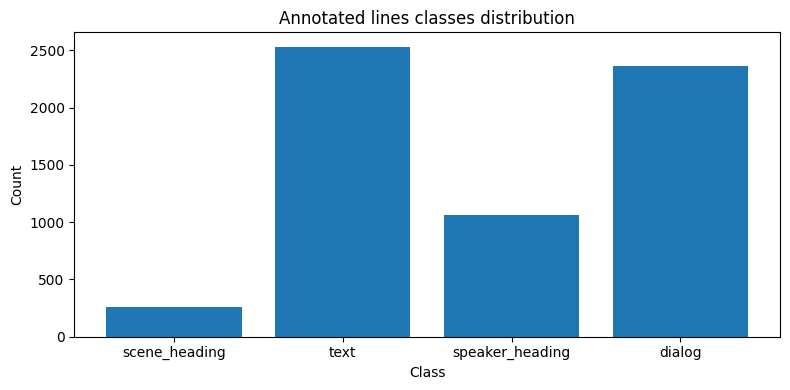

In [25]:
# Class distribution over the whole dataset
create_class_histogram(unique_labels, label_counts)

In [26]:
path_settings = PathSettings()
if os.path.exists(path_settings.training_split_path):
    split = read_file(path_settings.training_split_path)    
    train_indices = split.get("train_indices")
    validation_indices = split.get("validation_indices")
    print("Dataset split loaded.")
else:
    print("Creating dataset split...")
    indices = np.arange(len(dataset.labels))
    train_indices, validation_indices = train_test_split(indices, test_size=0.3, random_state=SEED)
    write_file({"train_indices": train_indices, "validation_indices": validation_indices}, "train_validation_split.pickle")

Dataset split loaded.


In [27]:
train_unique_labels, train_label_counts = np.unique(np.asarray(dataset.labels)[dataset.train_indices], return_counts=True)
validation_unique_labels, validation_label_counts = np.unique(np.asarray(dataset.labels)[dataset.validation_indices], return_counts=True)

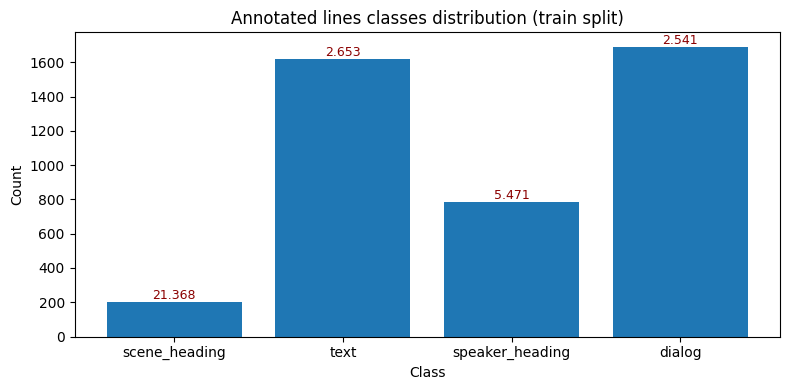

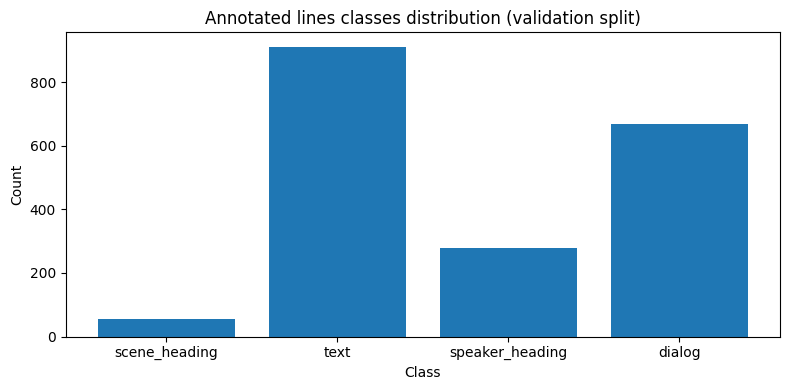

In [28]:
# Class distribution over train and validation set separately (with label weights for train set)
create_class_histogram(train_unique_labels, train_label_counts, title="Annotated lines classes distribution (train split)", class_weights=dataset.weight_per_class)
create_class_histogram(validation_unique_labels, validation_label_counts, title="Annotated lines classes distribution (validation split)")

### Training pipeline

In [29]:
class SctiptAnnotationTrainer:
    def __init__(self, data_settings: DataSettings, model_settings: ModelSettings, path_settings: PathSettings, training_settings: TrainingSettings):
        self.data_settings = data_settings
        self.model_settings = model_settings
        self.path_settings = path_settings
        self.training_settings = training_settings

        self._prepare_data()
        self._prepare_model()
        self._prepare_trainer()

    def _prepare_data(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        dataset = ScriptAnnotationDataset(self.path_settings, self.data_settings, self.model_settings.model_name)
        self.train_dataset = Subset(dataset, dataset.train_indices)
        self.validation_dataset = Subset(dataset, dataset.validation_indices)
        self.preprocessor = dataset.preprocessor
        self.data_collator = DataCollatorWithPadding(self.preprocessor)

    def _prepare_model(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model_specific_settings = self.model_settings.model_dump(exclude="model_name")
        self.model = AutoModelForSequenceClassification.from_pretrained(
            self.model_settings.model_name, 
            num_labels=self.data_settings.classes_num, 
            device_map=self.device,
            **model_specific_settings
        )
        self.metric = evaluate.load("hyperml/balanced_accuracy")
        
    def _prepare_trainer(self):
        self.trainer = Trainer(
            model=self.model,
            args=TrainingArguments(**self.training_settings.model_dump()),
            train_dataset=self.train_dataset,
            eval_dataset=self.validation_dataset,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
            data_collator=self.data_collator,
            compute_metrics=self.compute_metrics,
        )
                
    def compute_metrics(self, eval_predictions):
        predictions, labels = eval_predictions
        predictions = np.argmax(predictions, axis=1)
        return self.metric.compute(predictions=predictions, references=labels)

    def train(self):
        output = self.trainer.train()
    
    def predict(self, texts: list[str], model_to_load_path=None):
        def tokenize_fn(batch):
            return self.preprocessor(batch["text"], padding=False)
            
        if model_to_load_path:
            self.trainer.model = AutoModelForSequenceClassification.from_pretrained(model_to_load_path, device_map=self.device)

        data = {"text": texts, "label": [0] * len(texts)}
        test_dataset = HF_Dataset.from_dict(data)
        test_dataset = test_dataset.map(tokenize_fn, batched=True)
        prediction = self.trainer.predict(test_dataset)
        predictions = prediction.predictions.argmax(-1)
        for prediction, text in zip(predictions, texts):
            print(f"Text:\n{text}\nPrediction: {self.data_settings.class_to_heading_mapping[prediction]}\n")

In [30]:
# Uncomment to run training
# trainer = SctiptAnnotationTrainer(DataSettings(), ModelSettings(), PathSettings(), TrainingSettings())
# trainer.train()

In [31]:
# Uncomment to get predictions on test data

# texts = [
#     "INT. LONG CORRIDOR UPSTAIRS - SAME",
#     "The elevators on left. Many doorways to various courtrooms on",
#     "right. Each door marked with a hanging sign. The first sign reads",
#     "“Court of General Sessions. Part I”. The second sign reads “Court",
#     "of General Sessions. Part II” etc. An elevator door opens and a",
#     "number of people exit and walk down the corridor. Other people,",
#     "men and women, stand in the corridor talking. The whole feeling is",
#     "one of movement, activity, intense concentration. Everyone has a",
#     "purpose. -Camera dollies down the corridor, following a group of",
#     "people who exited from the elevator. People peel off from the",
#     "group at various doors. At each door stands a guard. People move",
#     "in and out of the doors. Camera reaches the door marked “Part VI”,",
#     "and pans around to face the door. A guard stands in front of it,",
#     "impassively. No one else is in front of the door, as compared to",
#     "the knots of whispering people in front of all the other doors.",
#     "5TH JUROR",
#     "I never knew they locked the door.",
#     "10TH JUROR",
#     "Sure they lock the door. What'd you",
#     "think?"
# ]
# trainer.predict(texts) # model_to_load_path="/kaggle/working/results/checkpoint-1345"

### Hyperparameters validation

In [32]:
class SctiptAnnotationHyperparamsValidation(SctiptAnnotationTrainer):
    def __init__(self, data_settings, model_settings, path_settings, training_settings, validation_settings):
        super().__init__(data_settings, model_settings, path_settings, training_settings)
        self.validation_settings = validation_settings
        
    def _prepare_data(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        dataset = ScriptAnnotationDataset(self.path_settings, self.data_settings, self.model_settings.model_name)
        self.train_dataset = Subset(dataset, dataset.train_indices)
        self.validation_dataset = Subset(dataset, dataset.validation_indices)
        self.preprocessor = dataset.preprocessor
        self.data_collator = DataCollatorWithPadding(self.preprocessor)

    def _prepare_model(self):
        """Returns model initializer."""
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model_specific_settings = self.model_settings.model_dump(exclude="model_name")
        model_name = self.model_settings.model_name
        classes_num = self.data_settings.classes_num
        device = self.device
        
        def model_init(trial):
             model = AutoModelForSequenceClassification.from_pretrained(
                model_name,
                num_labels=classes_num,
                device_map=device,
                **model_specific_settings
             )
             return model
            
        self.model_init = model_init
        self.metric = evaluate.load("hyperml/balanced_accuracy")
        
    def _prepare_trainer(self):            
        self.trainer = Trainer(
            model_init=self.model_init,
            args=TrainingArguments(**self.training_settings.model_dump(), save_total_limit=1),
            train_dataset=self.train_dataset,
            eval_dataset=self.validation_dataset,
            data_collator=self.data_collator,
            compute_metrics=self.compute_metrics,
        )
    
    @staticmethod
    def compute_objective(metrics):
        return metrics["eval_balanced_accuracy"]
        
    def get_hp_space(self, trial):
        validation_settings_dict = self.validation_settings.model_dump(exclude=("trials_num", "base_training_args"))
        define_suggestion = lambda trial, key, value: getattr(trial, f"suggest_{value['type']}")(key, *value["values"], **value["args"])
        return {key:  define_suggestion(trial, key, value) for key, value in validation_settings_dict.items()}

    def run(self):
        best_run = self.trainer.hyperparameter_search(
            direction="maximize",
            backend="optuna",
            hp_space=self.get_hp_space,
            n_trials=self.validation_settings.trials_num,
            compute_objective=self.compute_objective,

        )
        print(best_run)

In [33]:
validation_settings = ValidationSettings(trials_num=10)
training_settings = TrainingSettings(**validation_settings.base_training_args)
validation = SctiptAnnotationHyperparamsValidation(DataSettings(), ModelSettings(), PathSettings(), training_settings, validation_settings)
validation.run()

ASSERTION: other: FADE IN:

Dataset split loaded.


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-12-25 20:52:16,272] A new study created in memory with name: no-name-71a1e9ba-697b-4c89-8c3d-54776c7d5e4f
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


* Trackio project initialized: huggingface
* Trackio metrics will be synced to Hugging Face Dataset: FukuRo11/trackio-dataset
* Found existing space: https://huggingface.co/spaces/FukuRo11/trackio
* View dashboard by going to: https://FukuRo11-trackio.hf.space/


* Created new run: base_experiment


Epoch,Training Loss,Validation Loss,Balanced Accuracy
1,0.521700,0.567172,0.921793
2,0.460000,0.509167,0.946431
3,0.411000,0.513264,0.950057


* Run finished. Uploading logs to Trackio (please wait...)


[I 2025-12-25 20:54:24,372] Trial 0 finished with value: 0.9500574133312144 and parameters: {'learning_rate': 1.571134443294715e-05, 'lr_scheduler_type': 'linear', 'warmup_ratio': 0.09030974957473102, 'weight_decay': 0.05483042064965498, 'label_smoothing_factor': 0.10909813345411791}. Best is trial 0 with value: 0.9500574133312144.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Balanced Accuracy
1,0.562500,0.669838,0.894765
2,0.486400,0.539283,0.940461
3,0.383300,0.532544,0.952951


* Run finished. Uploading logs to Trackio (please wait...)


[I 2025-12-25 20:56:28,249] Trial 1 finished with value: 0.9529510437594184 and parameters: {'learning_rate': 4.192066848510971e-05, 'lr_scheduler_type': 'linear', 'warmup_ratio': 0.02603377552489954, 'weight_decay': 0.07507178924341239, 'label_smoothing_factor': 0.023054952708208707}. Best is trial 1 with value: 0.9529510437594184.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Balanced Accuracy
1,0.553700,0.582017,0.910048
2,0.465000,0.522306,0.937071
3,0.428800,0.528760,0.936890


* Run finished. Uploading logs to Trackio (please wait...)


[I 2025-12-25 20:58:33,203] Trial 2 finished with value: 0.9368898364896455 and parameters: {'learning_rate': 1.1168295641243968e-05, 'lr_scheduler_type': 'cosine', 'warmup_ratio': 0.09831678254363152, 'weight_decay': 0.022478883725030548, 'label_smoothing_factor': 0.09216658798798959}. Best is trial 1 with value: 0.9529510437594184.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Balanced Accuracy
1,0.637600,0.650505,0.899312
2,0.462700,0.528659,0.937865
3,0.401900,0.528071,0.947961


* Run finished. Uploading logs to Trackio (please wait...)


[I 2025-12-25 21:00:38,434] Trial 3 finished with value: 0.9479607338522478 and parameters: {'learning_rate': 2.5334375477874214e-05, 'lr_scheduler_type': 'cosine', 'warmup_ratio': 0.1563419198558404, 'weight_decay': 0.015421810274280245, 'label_smoothing_factor': 0.09622112201470827}. Best is trial 1 with value: 0.9529510437594184.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Balanced Accuracy
1,0.999100,0.603789,0.924678
2,0.426700,0.525304,0.951865
3,0.390600,0.525398,0.951125


* Run finished. Uploading logs to Trackio (please wait...)


[I 2025-12-25 21:02:43,579] Trial 4 finished with value: 0.9511254258167606 and parameters: {'learning_rate': 4.238554355052449e-05, 'lr_scheduler_type': 'linear', 'warmup_ratio': 0.18309512482462248, 'weight_decay': 0.0563842101612827, 'label_smoothing_factor': 0.022710959343628784}. Best is trial 1 with value: 0.9529510437594184.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Balanced Accuracy
1,0.554600,0.635686,0.915770
2,0.448700,0.510423,0.953733
3,0.396200,0.524768,0.953401


* Run finished. Uploading logs to Trackio (please wait...)


[I 2025-12-25 21:04:47,779] Trial 5 finished with value: 0.9534006228123162 and parameters: {'learning_rate': 1.906571609416521e-05, 'lr_scheduler_type': 'cosine', 'warmup_ratio': 0.07883962813572941, 'weight_decay': 0.03947118735181894, 'label_smoothing_factor': 0.08896601514657786}. Best is trial 5 with value: 0.9534006228123162.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Balanced Accuracy
1,0.632500,0.575471,0.934711
2,0.444800,0.531980,0.936423


* Run finished. Uploading logs to Trackio (please wait...)


[I 2025-12-25 21:06:07,524] Trial 6 pruned. 
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Balanced Accuracy
1,0.524800,0.602977,0.916121
2,0.464000,0.504805,0.953009
3,0.394400,0.520311,0.948219


* Run finished. Uploading logs to Trackio (please wait...)


[I 2025-12-25 21:08:13,240] Trial 7 finished with value: 0.9482186352978625 and parameters: {'learning_rate': 2.314187396585587e-05, 'lr_scheduler_type': 'cosine', 'warmup_ratio': 0.0997160590082909, 'weight_decay': 0.03237842953396387, 'label_smoothing_factor': 0.0674448498479898}. Best is trial 5 with value: 0.9534006228123162.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Balanced Accuracy
1,0.529500,0.601131,0.898971


* Run finished. Uploading logs to Trackio (please wait...)


[I 2025-12-25 21:08:52,982] Trial 8 pruned. 
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Balanced Accuracy
1,0.567000,0.591096,0.884678


* Run finished. Uploading logs to Trackio (please wait...)


[I 2025-12-25 21:09:32,911] Trial 9 pruned. 


BestRun(run_id='5', objective=0.9534006228123162, hyperparameters={'learning_rate': 1.906571609416521e-05, 'lr_scheduler_type': 'cosine', 'warmup_ratio': 0.07883962813572941, 'weight_decay': 0.03947118735181894, 'label_smoothing_factor': 0.08896601514657786}, run_summary=None)
